# Introduction

This notebook contains all the code needed to automatically calculate the Facial-Width-Height ratio based on an image using the `face_recognition` package.  
**See: https://github.com/ageitgey/face_recognition**

In [1]:
NAME = 'FWHR_calculator'
PYTHON_VERSION = '3.5'
AUTHOR = 'Ties de Kok'

## Looking for examples? Click here: [Examples](#examples)

# Preamble

## Imports

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import math

from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw
import face_recognition

import urllib.request 

**All the heavy-lifting is done by the `face_recognition` package, you need to have it installed!**  
**See: https://github.com/ageitgey/face_recognition**

# Main Code

### Function to load an image

This function loads an image from the drive or downloads it from a link if `url` is set to `True`.

In [4]:
def load_image(path, url=False):
    if not url:
        return face_recognition.load_image_file(path)
    else:
        if path[-3:] == 'jpg' or  path[-3:] == 'peg':
            urllib.request.urlretrieve(path, 'tmp.jpg')
            return face_recognition.load_image_file('tmp.jpg')
        elif path[-3:] == 'png':
            urllib.request.urlretrieve(path, 'tmp.png')
            return face_recognition.load_image_file('tmp.png')
        else:
            print("Unknown image type")

### Function to get the contour face points

This function calculates the coordinates for the corners of the "FWHR" box.  
*Note 1:* it is possible to calculate the top line based on either the bottom of the eyebrows (`top = "eyebrow"`) or the eyelids (`top = "eyelid"`).  
*Note 2:* to counter-act small amounts of rotation it will by default take the average between the height of the two top points.

In [5]:
def get_face_points(points, method='average', top='eyebrow'):
    width_left, width_right = points[0], points[16]
    
    if top == 'eyebrow':
        top_left = points[18]
        top_right = points[25]
        
    elif top == 'eyelid':
        top_left = points[37]
        top_right = points[43] 
        
    else:
        raise ValueError('Invalid top point, use either "eyebrow" or "eyelid"')
        
    bottom_left, bottom_right = points[50], points[52]
    
    if method == 'left':
        coords = (width_left[0], width_right[0], top_left[1], bottom_left[1])
        
    elif method == 'right':
        coords = (width_left[0], width_right[0], top_right[1], bottom_right[1])
        
    else:
        top_average = int((top_left[1] + top_right[1]) / 2)
        bottom_average = int((bottom_left[1] + bottom_right[1]) / 2)
        coords = (width_left[0], width_right[0], top_average, bottom_average)
        
    ## Move the line just a little above the top of the eye to the eyelid    
    if top == 'eyelid':
        coords = (coords[0], coords[1], coords[2] - 4, coords[3])
        
    return {'top_left' : (coords[0], coords[2]),
            'bottom_left' : (coords[0], coords[3]),
            'top_right' : (coords[1], coords[2]),
            'bottom_right' : (coords[1], coords[3])
           }

### Function to check suitability of picture

This function checks whether a picture contains a person that is looking straight at the camera.

In [6]:
def good_picture_check(p, debug=False):
    ## To scale for picture size
    width_im = (p[16][0] - p[0][0]) / 100
    
    ## Difference in height between eyes
    eye_y_l = (p[37][1] + p[41][1]) / 2.0
    eye_y_r = (p[44][1] + p[46][1]) / 2.0
    eye_dif = (eye_y_r - eye_y_l) / width_im
    
    ## Difference top / bottom point nose 
    nose_dif = (p[30][0] - p[27][0]) / width_im
    
    ## Space between face-edge to eye, left vs. right
    left_space = p[36][0] - p[0][0]
    right_space = p[16][0] - p[45][0]
    space_ratio = left_space / right_space
    
    if debug:
        print(eye_dif, nose_dif, space_ratio)
    
    ## These rules are not perfect, determined by trying a bunch of "bad" pictures
    if eye_dif > 5 or nose_dif > 3.5 or space_ratio > 3:
        return False
    else:
        return True

### Function to calculate the FWHR

This function calculates the FWHR based on the corners: `Width / Height`

In [7]:
def FWHR_calc(corners):
    width = corners['top_right'][0] - corners['top_left'][0]
    height = corners['bottom_left'][1] - corners['top_left'][1]
    return float(width) / float(height)

### Function to show the FWHR box on the image

This function shows the FWHR box on the original image.

In [8]:
def show_box(image, corners):
    pil_image = Image.fromarray(image)
    w, h = pil_image.size
    
    ## Automatically determine width of the line depending on size of picture
    line_width = math.ceil(h / 100)
    
    d = ImageDraw.Draw(pil_image) 
    d.line([corners['bottom_left'], corners['top_left']], width = line_width)
    d.line([corners['bottom_left'], corners['bottom_right']], width = line_width)
    d.line([corners['top_left'], corners['top_right']], width = line_width)
    d.line([corners['top_right'], corners['bottom_right']], width = line_width)
    
    imshow(pil_image)

### Final function that combines the previous functions

This function combines all the previous logic into one function.  

Arguments:

`image_path` $\rightarrow$ path or URL to image  
`url` $\rightarrow$ set to `True` if `image_path` is a url  
`show` $\rightarrow$ set to `False` if you only want it to return the FWHR  
`method` $\rightarrow$ determines which eye to use for the top point: `left`, `right`, or `average`  
`top` $\rightarrow$ determines whether to use the `eyebrow` as top point or `eyelid` as top point  


In [9]:
def get_fwhr(image_path, url=False, show=True, method='average', top='eyelid'):
    image = load_image(image_path, url)
    landmarks = face_recognition.api._raw_face_landmarks(image)
    landmarks_as_tuples = [(p.x, p.y) for p in landmarks[0].parts()]
    
    if good_picture_check(landmarks_as_tuples): 
        corners = get_face_points(landmarks_as_tuples, method=method, top = top)
        fwh_ratio = FWHR_calc(corners)
        
        if show:
            print('The Facial-Width-Height ratio is: {}'.format(fwh_ratio))
            show_box(image, corners)
        else:
            return fwh_ratio
    else:
        if show:
            print("Picture is not suitable to calculate fwhr.")
            imshow(image)
        else:
            return None

# Examples
<a id='examples'></a>

## Basic example

The Facial-Width-Height ratio is: 1.9367088607594938


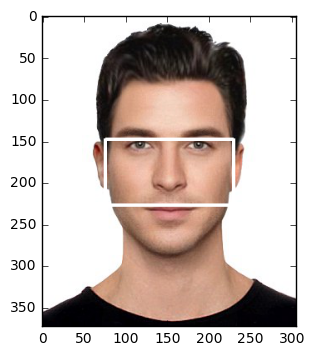

In [10]:
guy_url = 'http://i.dailymail.co.uk/i/pix/2015/03/30/04/271843AB00000578-0-image-a-86_1427687469357.jpg'
get_fwhr(guy_url, url=True)

## Difference `eyelid` vs. `eyebrow`

The Facial-Width-Height ratio is: 1.9285714285714286


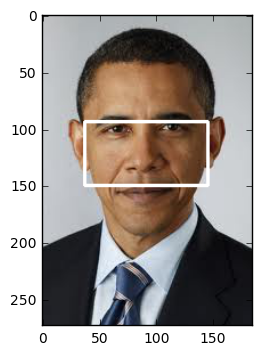

In [11]:
obama_url = 'http://mienshiang.com/wp-content/uploads/images-29.jpg'
get_fwhr(obama_url, url=True, top = 'eyelid')

The Facial-Width-Height ratio is: 1.8


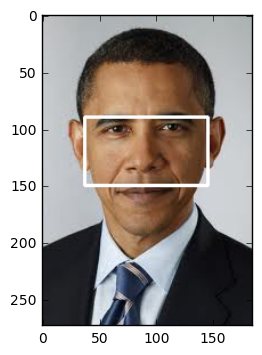

In [12]:
get_fwhr(obama_url, url=True, top = 'eyebrow')

## FWHR only

In [13]:
get_fwhr(obama_url, url=True, top = 'eyebrow', show=False)

1.8

## Detection of bad picture

Picture is not suitable to calculate fwhr.


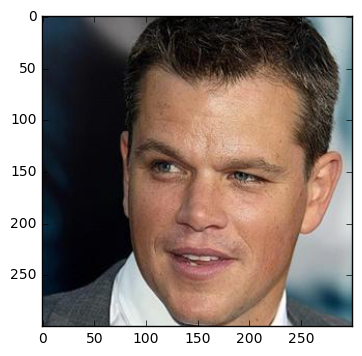

In [14]:
bad_img_url_1 = 'https://s-media-cache-ak0.pinimg.com/originals/0d/02/d2/0d02d28791fab2a6f056648dc174033c.jpg'
get_fwhr(bad_img_url_1, url=True)

Picture is not suitable to calculate fwhr.


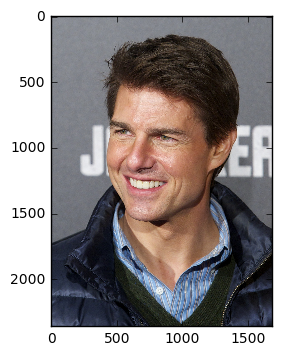

In [15]:
bad_img_url_2 = 'https://s-media-cache-ak0.pinimg.com/originals/35/7f/f6/357ff6776c8ec6f565d06e05f902f88b.jpg'
get_fwhr(bad_img_url_2, url=True)

# Explanation

The data points used in the functions above use this picture as reference:

In [102]:
from IPython.display import Image as ImageShow
ImageShow(url = 'https://cdn-images-1.medium.com/max/1600/1*AbEg31EgkbXSQehuNJBlWg.png')